In [6]:
!pip install kaggle

In [9]:
import json
import zipfile
import os

!mkdir -p ~/content/.kaggle
!touch ~/content/.kaggle/kaggle.json




In [14]:
os.environ['KAGGLE_USERNAME'] = 'username'
os.environ['KAGGLE_KEY'] = 'KEY'
api_token = {"username":"username","key":"KEY"}


with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /content/.kaggle/kaggle.json
!kaggle config set -n path -v /content/dataset

Expecting value: line 1 column 1 (char 0)


In [15]:
!kaggle datasets list -s "The Simpsons Characters"


ref                                                         title                                      size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/alexattia/the-simpsons-characters-dataset          The Simpsons Characters Data                1GB  2018-04-13 22:55:01          17040        470  0.7941176        
datasets/paultimothymooney/zipfiles                         The Simpsons Characters Data (zipfiles)   530MB  2017-11-03 18:20:30            184          4  0.75             
datasets/phsaikiran/the-simpsons-characters-data-tfrecords  The Simpsons Characters Data - TFRecords  431MB  2021-01-24 20:44:49              7          1  0.375            
datasets/williamu32/dataset-bart-or-homer                   The Simpsons (Bart and Homer) Data          8MB  2021-06-12 20:57:05  

In [17]:
!kaggle datasets download -d "alexattia/the-simpsons-characters-dataset"

 99% 1.06G/1.08G [00:05<00:00, 217MB/s]
100% 1.08G/1.08G [00:05<00:00, 220MB/s]


In [ ]:
!unzip '/content/the-simpsons-characters-dataset.zip' -d '/content/dataset/'

In [ ]:
!pip install caer

## Now, a custom library needs to be installed. But this requires GPU.

In [ ]:
!pip install canaro

In [22]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc

## First, need to declare image size. All images should be converted into this size. This dataset works best on 80*80. But this can be different for other dataset. Also, this tutorial mostly focus on grayscale image. Color is not important for this implementation That is why channel = 1 (Grayscale).

In [23]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'/content/dataset/simpsons_dataset'

### Lets select only first 10 characters with most images

In [24]:
# Creating a character dictionary, sorting it in descending order
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [25]:
#  Getting the first 10 categories with the most number of images
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

## Training

In [28]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True, verbose=False)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 37s


In [29]:
# Number of training samples
len(train)

13811

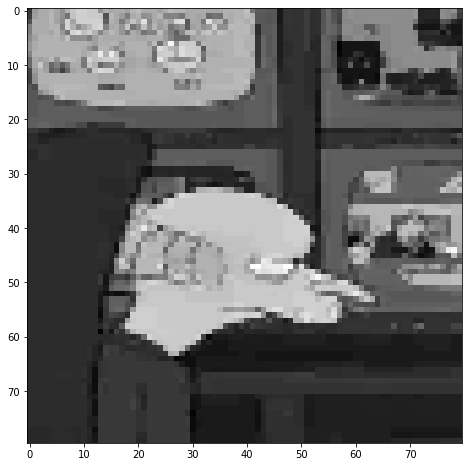

In [31]:
# Visualizing the data (OpenCV doesn't display well in Jupyter notebooks)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(train[0][0], cmap='gray')
plt.show()

## Prepare image set and labels. 

In [32]:
# Separating the array and corresponding labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

## Normalize

In [33]:
from tensorflow.keras.utils import to_categorical

# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
# Converting numerical labels to binary class vectors
labels = to_categorical(labels, len(characters))

## Slit Train & Test Set

In [35]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

## Saving memory. This is not necessity but required for efficiency.

In [36]:
del train
del featureSet
del labels 
gc.collect()

174

In [37]:
# Useful variables when training
BATCH_SIZE = 32
EPOCHS = 10

## Image data generator (introduces randomness in network ==> better accuracy)

In [38]:
# Image data generator (introduces randomness in network ==> better accuracy)
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [39]:
# Create our model (returns a compiled model)
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(characters), 
                                         loss='binary_crossentropy', decay=1e-7, learning_rate=0.001, momentum=0.9,
                                         nesterov=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 80, 80, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 78, 78, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 39, 39, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 39, 39, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 37, 37, 64)        36928     
                                                      

In [41]:
# Training the model

from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10
345/345 [==============================] - 35s 68ms/step - loss: 0.3387 - accuracy: 0.1603 - val_loss: 0.3361 - val_accuracy: 0.1585 - lr: 0.0100
Epoch 2/10
345/345 [==============================] - 20s 58ms/step - loss: 0.3237 - accuracy: 0.1601 - lr: 0.0100
Epoch 3/10
345/345 [==============================] - 20s 57ms/step - loss: 0.3230 - accuracy: 0.1623 - lr: 0.0100
Epoch 4/10
345/345 [==============================] - 20s 58ms/step - loss: 0.3207 - accuracy: 0.1687 - lr: 0.0100
Epoch 5/10
345/345 [==============================] - 20s 59ms/step - loss: 0.3096 - accuracy: 0.2141 - lr: 0.0100
Epoch 6/10
345/345 [==============================] - 20s 59ms/step - loss: 0.3055 - accuracy: 0.2350 - lr: 0.0100
Epoch 7/10
345/345 [==============================] - 21s 61ms/step - loss: 0.3014 - accuracy: 0.2557 - lr: 0.0100
Epoch 8/10
345/345 [==============================] - 20s 59ms/step - loss: 0.2975 - accuracy: 0.2724 - lr: 0.0100
Epoch 9/10
345/345 [==================

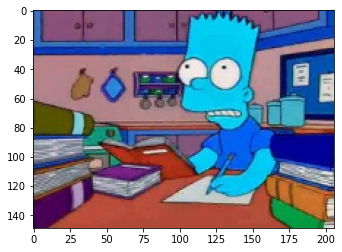

In [44]:
test_path = r'/content/dataset/kaggle_simpson_testset/kaggle_simpson_testset/bart_simpson_40.jpg'

img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [45]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [46]:
predictions = model.predict(prepare(img))

In [49]:
predictions 

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [51]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [47]:
# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])

lisa_simpson
